In [558]:
# Necessary Imports
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pywt
import torch
import torch.nn as nn
import torch.optim as optim
from astropy.constants import c
from astropy import units as u

<h4> Correct for noise using wavelet denoising </h4>

In [559]:
"""
    Removes noise from the spectrum using wavelet decomposition 
    Name:       denoise()
    Parameters: 
                flux: flux data from the spectrum
                wavelet = 'db4': wavelet family (Daubechies w/ 4 vanishing moments)
                level = 1: first-level approx and detail coefficients
                threshold_type = 'soft': threshold type

    Returns:
                denoised_flux: flux without noise
"""
def denoise(flux, wavelet='db4', level=1, threshold_type='soft'):
    # Perform wavelet decomposition and get coefficients
    coeffs = pywt.wavedec(flux, wavelet, level=level)

    # Calculate the threshold
    threshold = np.std(coeffs[-1]) * np.sqrt(2 * np.log(len(flux)))

    # Apply threshold to detail coefficients
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold, mode=threshold_type)

    # Reconstruct the denoised flux
    denoised_flux = pywt.waverec(coeffs, wavelet)

    return denoised_flux



In [560]:
# Load spectrum
data = fits.getdata('hlsp_space_hst_stis_toi-1201_g140m_v1_component-spec.fits')
w, f , e, dq = data['WAVELENGTH'], data['FLUX'], data['ERROR'], data['DQ']
mask = (w > 1210) & (w < 1221)

# Denoise the spectrum
flux_denoised = denoise(f[mask]) # already masked!

# Make sure array sizes are consitent
try:
    assert len(w[mask]) == len(flux_denoised)
except AssertionError as e:
    flux_denoised = np.delete(flux_denoised, -1)

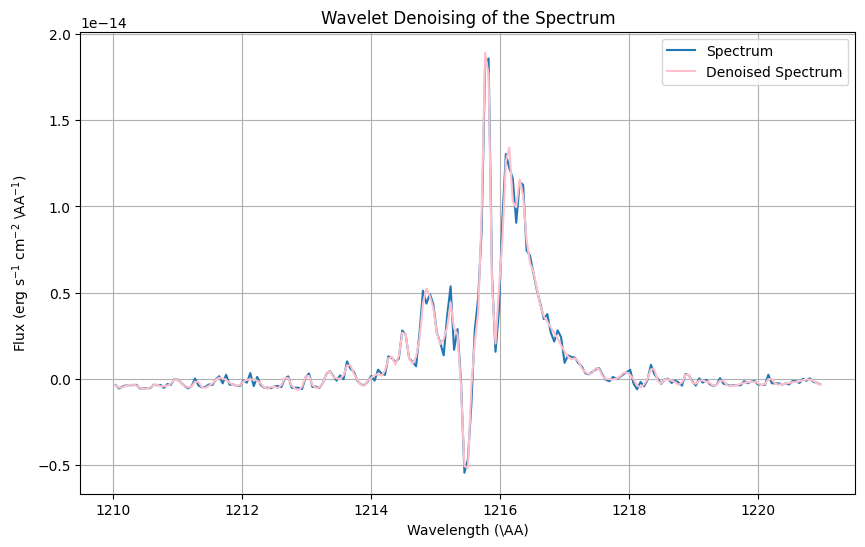

In [561]:
# Plot the updated spectrum
plt.figure(figsize=(10, 6))
plt.plot(w[mask], f[mask], label='Spectrum')
plt.plot(w[mask], flux_denoised, label='Denoised Spectrum', color='pink')
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.legend()
plt.title('Wavelet Denoising of the Spectrum')
plt.grid(True)
plt.show()

<h4> Prepare the data </h4> 

In [562]:
# Normalize the wavelengths and denoised flux
normalized_denoised_flux = (flux_denoised - np.min(flux_denoised)) / (np.max(flux_denoised) - np.min(flux_denoised))
normalized_x = (w[mask] - np.min(w[mask])) / (np.max(w[mask]) - np.min(w[mask]))

# Split into training and validation sets (80% training)
num_samples = len(normalized_x)
train_size = int(0.8 * num_samples)
x_train, x_val = normalized_x[:train_size], normalized_x[train_size:]
flux_train, flux_val = normalized_denoised_flux[:train_size], normalized_denoised_flux[train_size:] 

# Organize features and labels
x_train_tensor = torch.tensor(x_train, dtype=torch.float32, requires_grad=True).view(-1, 1)
flux_train_tensor = torch.tensor(flux_train, dtype=torch.float32, requires_grad=True).view(-1, 1)
x_val_tensor = torch.tensor(x_val, dtype=torch.float32, requires_grad=True).view(-1, 1)
flux_val_tensor = torch.tensor(flux_val, dtype=torch.float32, requires_grad=True).view(-1, 1)

# Create data loaders
train_dataset = torch.utils.data.TensorDataset(x_train_tensor, flux_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = torch.utils.data.TensorDataset(x_val_tensor, flux_val_tensor)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32)


<h4> PINN without α(x) Ground Truth</h4>

In [563]:
# Constants
lya_lambda = 1215.67 # Angstroms
c = 2997924580000000000  # Angstroms/second

# Define the PINN model (maybe adjust how linear is used later ??)
class PINNModel(nn.Module):
    def __init__(self):
        super(PINNModel, self).__init__()
        self.fc1 = nn.Linear(1, 64)  # 1 input dim(normalized wavelength), 64 hidden dim
        self.fc2 = nn.Linear(64, 64)  # 64 hidden dim
        self.fc3 = nn.Linear(64, 1)  # 1 output dim(predicted flux)

        self.alpha_x = nn.Parameter(torch.tensor(1.0, requires_grad=True)) # keep adjusting me until a good reconstruction is made !

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        flux_pred = self.fc3(x)
        return flux_pred

In [564]:
"""
    Calculates both the Data-Driven Loss and Physics-Constraint Loss
    Name:       pinn_loss()
    Parameters: 
                flux_pred: predicted flux value
                x_train_tensor: normalized wavelengths for the training set
                flue_true: true flux values of the training set
                pin_model: model being trained
                flux_model_derivative: derivative of flux_pred (only need a value when called in the val set)
                training: boolean for if the call is in within the training set or not
    Returns:
                total_loss: both the physics constraint loss and data-driven loss
                flux_pred_derivative: the derivative of flux_pred (only calculated in the training loop)
"""
def pinn_loss(flux_pred, x_train_tensor, flux_true, pin_model, flux_pred_derivative, training = True):
    # Data-Driven Loss calculation
    data_loss = nn.MSELoss()(flux_pred, flux_true)

    # Left-hand side of the Radiative Transfer Equation
    alpha_x = pin_model.alpha_x
    intensity_pred = flux_pred / (c * lya_lambda * alpha_x)

    # Check if in training loop
    if training:
        # Calculate the partial derivative of flux_pred
        flux_pred_derivative = torch.autograd.grad(flux_pred, x_train_tensor, grad_outputs=torch.ones_like(flux_pred), create_graph=True)[0]

    # Make sure all tensors are the same shape
    flux_pred_derivative = flux_pred_derivative[:flux_pred.shape[0]]
    alpha_x = alpha_x.expand_as(flux_pred) # check if i should be resized !!
    intensity_pred = intensity_pred[:flux_pred.shape[0]]

    # Calculate the residual (difference between left-hand side and right-hand side of the RTE)
    residual = flux_pred_derivative + alpha_x * flux_pred - intensity_pred
    
    # Physics constraint loss (MSE)
    physics_loss = torch.mean(torch.square(residual))

    # Combine both losses
    total_loss = data_loss + physics_loss

    return total_loss, flux_pred_derivative



In [565]:
# Intialize the model and set up optimizier
pin_model = PINNModel()
optimizer = torch.optim.Adam(pin_model.parameters(), lr=0.001)

# Traing Loop
num_epochs = 1000 # adjust me to be at the plateau of the validation loss (plot vall loss!)

for epoch in range(num_epochs):
    # Training mode
    pin_model.train()
    # Set all gradients to 0
    optimizer.zero_grad()

    # Forward pass 
    flux_pred = pin_model(x_train_tensor)

    # Calculate the PINN loss
    loss, flux_pred_derivative = pinn_loss(flux_pred, x_train_tensor, flux_train_tensor, pin_model, 0)

    # Backpropagation 
    loss.backward()

    # Update weights
    optimizer.step()

    # Validation set
    with torch.no_grad():
        # Evaluation mode
        pin_model.eval()
        val_flux_pred = pin_model(x_val_tensor)
        
        # Calculate the PINN loss
        val_loss, _ = pinn_loss(val_flux_pred, x_val_tensor, flux_val_tensor, pin_model, flux_pred_derivative, training=False) 
        
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}, Validation Loss: {val_loss.item()}")




Epoch 1/1000, Loss: 0.07798857241868973, Validation Loss: 0.04346209019422531
Epoch 2/1000, Loss: 0.05931689590215683, Validation Loss: 0.022611267864704132
Epoch 3/1000, Loss: 0.04902396351099014, Validation Loss: 0.015164380893111229
Epoch 4/1000, Loss: 0.04532618448138237, Validation Loss: 0.01453645434230566
Epoch 5/1000, Loss: 0.04504115507006645, Validation Loss: 0.01599610410630703
Epoch 6/1000, Loss: 0.04513980820775032, Validation Loss: 0.016607027500867844
Epoch 7/1000, Loss: 0.04425544664263725, Validation Loss: 0.015570176765322685
Epoch 8/1000, Loss: 0.042440369725227356, Validation Loss: 0.013326690532267094
Epoch 9/1000, Loss: 0.03996512293815613, Validation Loss: 0.010409721173346043
Epoch 10/1000, Loss: 0.03754369542002678, Validation Loss: 0.007858873344957829
Epoch 11/1000, Loss: 0.035767149180173874, Validation Loss: 0.005926662124693394
Epoch 12/1000, Loss: 0.03484158590435982, Validation Loss: 0.004639985505491495
Epoch 13/1000, Loss: 0.0349104106426239, Validatio